In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tensorflow.keras import applications
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dropout, Flatten, Dense
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
import requests
from PIL import Image
from io import BytesIO
import cv2
import pandas as pd
import numpy as np
import os

In [4]:
translate = {"cane": "Dog", "cavallo": "Horse", "elefante": "Elephant", "farfalla": "Butterfly", "gallina": "Chicken", "gatto": "Cat", "mucca": "Cow", "pecora": "Sheep", "scoiattolo": "Squirrel", "ragno": "Spider"}

In [11]:
#Getting data from the kaggle dataset and extracting it
print(os.listdir("raw-img/"))
FNS = os.listdir('raw-img/')
f = []
f2 = []
t = []
t2 = []

#goes through each directory and gathers all 10 animals categories
for i, dir in enumerate(FNS):
    filenames = os.listdir("raw-img/" + dir)
    count = 0
    for file in filenames:
        if count < 1400:
            f.append("raw-img/" + dir + "/" + file)
            t.append(translate[dir])
        else:
            f2.append("raw-img/" + dir + "/" + file)
            t2.append(translate[dir])
        count += 1

df = pd.DataFrame({'Filepath':f, 'Target':t})
dft = pd.DataFrame({'Filepath':f2, 'Target':t2})

#Splits the data into a train and test split with 80/20 split
train, test = train_test_split(df, test_size=0.2, random_state = 0)

['cane', 'cavallo', 'elefante', 'farfalla', 'gallina', 'gatto', 'mucca', 'pecora', 'ragno', 'scoiattolo']


In [12]:
#We preprocess the data using ImageDataGenerator which applies zooms, flips, and rotations to the images
animals_data = ImageDataGenerator(rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        rotation_range=30, 
        width_shift_range=0.1,
        height_shift_range=0.1,
        samplewise_center = True,
        )

animals_datatest = ImageDataGenerator(rescale=1./255, samplewise_center = True)
#moves the data into flow set
train_set = animals_data.flow_from_dataframe(train, x_col = 'Filepath', y_col = 'Target', target_size=(224, 224), interpolation = 'lanczos', validate_filenames = False)
test_set = animals_datatest.flow_from_dataframe(test, x_col = 'Filepath', y_col = 'Target', target_size=(224, 224), interpolation = 'lanczos', validate_filenames = False)

Found 10000 non-validated image filenames belonging to 10 classes.
Found 4000 non-validated image filenames belonging to 10 classes.


In [13]:
model = applications.VGG16(weights='imagenet', include_top = False, input_shape=(224, 224, 3))

flat1 = tf.keras.layers.Flatten()(model.output)
dropout1 = Dropout(0.1)(flat1)
class1 = tf.keras.layers.Dense(256, activation='relu')(dropout1)
dropout2 = Dropout(0.1)(class1)
output = tf.keras.layers.Dense(10, activation='softmax')(dropout2)
model = Model(inputs = model.inputs, outputs = output)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 1, verbose = 1, min_delta=0.0001, min_lr = 1e-8)

model.compile(loss = 'categorical_crossentropy', optimizer = optimizers.SGD(lr=1e-3, momentum=0.9), metrics = ['accuracy'])
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

c:\Python39\lib\site-packages\keras\optimizer_v2\gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [16]:
history = model.fit(train_set, epochs = 5, validation_data = test_set, callbacks=[ModelCheckpoint('VGG16.model', monitor='val_acc'), reduce_lr])

Epoch 1/5
313/313 [==============================] - 2058s 7s/step - loss: 0.6097 - accuracy: 0.7940 - val_loss: 0.3786 - val_accuracy: 0.8735 - lr: 0.0010
Epoch 2/5
313/313 [==============================] - ETA: 0s - loss: 0.3733 - accuracy: 0.8771INFO:tensorflow:Assets written to: VGG16.model\assets

Epoch 2: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
313/313 [==============================] - 2042s 7s/step - loss: 0.3733 - accuracy: 0.8771 - val_loss: 0.3936 - val_accuracy: 0.8805 - lr: 0.0010
Epoch 3/5
313/313 [==============================] - 2214s 7s/step - loss: 0.2040 - accuracy: 0.9374 - val_loss: 0.1912 - val_accuracy: 0.9442 - lr: 2.0000e-04
Epoch 4/5
313/313 [==============================] - ETA: 0s - loss: 0.1651 - accuracy: 0.9467INFO:tensorflow:Assets written to: VGG16.model\assets

Epoch 4: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
313/313 [==============================] - 2167s 7s/step - loss: 0.1651 - accuracy: 0.

[0.3785645663738251, 0.3936253488063812, 0.1911696046590805, 0.2023395597934723, 0.17764534056186676]
[0.8734999895095825, 0.8805000185966492, 0.9442499876022339, 0.937250018119812, 0.9490000009536743]


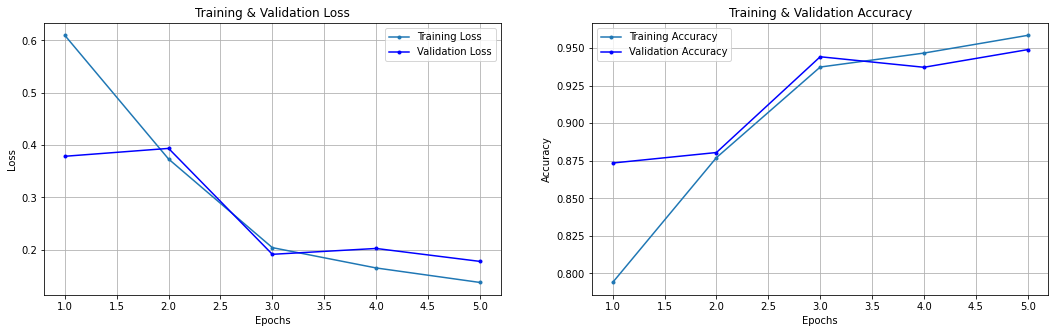

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [21]:
#Graphing the validation and traing loss/accuracy
loss_vals = history.history['loss']
val_loss_vals = history.history['val_loss']
epochs = range(1, len(history.history['accuracy'])+1)
print(val_loss_vals)

f, graphs = plt.subplots(nrows=1,ncols=2,figsize=(18,5))
    
graphs[0].plot(epochs, loss_vals,  marker='.', label='Training Loss')
graphs[0].plot(epochs, val_loss_vals, marker='.', color = 'blue', label='Validation Loss')
graphs[0].set_title('Training & Validation Loss')
graphs[0].set_xlabel('Epochs')
graphs[0].set_ylabel('Loss')
graphs[0].legend(loc='best')
graphs[0].grid(True)

acc_vals = history.history['accuracy']
val_acc_vals = history.history['val_accuracy']
print(val_acc_vals)
graphs[1].plot(epochs, acc_vals, marker='.', label='Training Accuracy')
graphs[1].plot(epochs, val_acc_vals, marker='.', color = 'blue', label='Validation Accuracy')
graphs[1].set_title('Training & Validation Accuracy')
graphs[1].set_xlabel('Epochs')
graphs[1].set_ylabel('Accuracy')
graphs[1].legend(loc='best')
graphs[1].grid(True)

plt.show()
plt.close()